In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install kaggle

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/kaggle'

In [ ]:
!kaggle datasets download -d dschettler8845/brats-2021-task1

Dataset URL: https://www.kaggle.com/datasets/dschettler8845/brats-2021-task1
License(s): copyright-authors
100% 12.3G/12.3G [02:46<00:00, 85.4MB/s]
100% 12.3G/12.3G [02:46<00:00, 79.3MB/s]


In [ ]:
import zipfile

# Define the path to your zip file
file_path = '/content/brats-2021-task1.zip'  # Replace 'your_file.zip' with your file's name

# Unzip the file to a specific destination
with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/brain_tumor')

In [ ]:
#extract dataset to google drive
!tar -xvf "/content/brain_tumor/BraTS2021_Training_Data.tar" -C "/content/drive/MyDrive/kaggle/Training/"     #[run this cell to extract tar files]

Streaming output truncated to the last 5000 lines.
./BraTS2021_00590/BraTS2021_00590_t1ce.nii.gz
./BraTS2021_00590/BraTS2021_00590_t2.nii.gz
./BraTS2021_00591/
./BraTS2021_00591/BraTS2021_00591_flair.nii.gz
./BraTS2021_00591/BraTS2021_00591_seg.nii.gz
./BraTS2021_00591/BraTS2021_00591_t1.nii.gz
./BraTS2021_00591/BraTS2021_00591_t1ce.nii.gz
./BraTS2021_00591/BraTS2021_00591_t2.nii.gz
./BraTS2021_00593/
./BraTS2021_00593/BraTS2021_00593_flair.nii.gz
./BraTS2021_00593/BraTS2021_00593_seg.nii.gz
./BraTS2021_00593/BraTS2021_00593_t1.nii.gz
./BraTS2021_00593/BraTS2021_00593_t1ce.nii.gz
./BraTS2021_00593/BraTS2021_00593_t2.nii.gz
./BraTS2021_00594/
./BraTS2021_00594/BraTS2021_00594_flair.nii.gz
./BraTS2021_00594/BraTS2021_00594_seg.nii.gz
./BraTS2021_00594/BraTS2021_00594_t1.nii.gz
./BraTS2021_00594/BraTS2021_00594_t1ce.nii.gz
./BraTS2021_00594/BraTS2021_00594_t2.nii.gz
./BraTS2021_00596/
./BraTS2021_00596/BraTS2021_00596_flair.nii.gz
./BraTS2021_00596/BraTS2021_00596_seg.nii.gz
./BraTS2021_0

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import nibabel as nib
import tensorflow as tf
from tensorflow.keras.utils import Sequence

import warnings
warnings.filterwarnings('ignore')


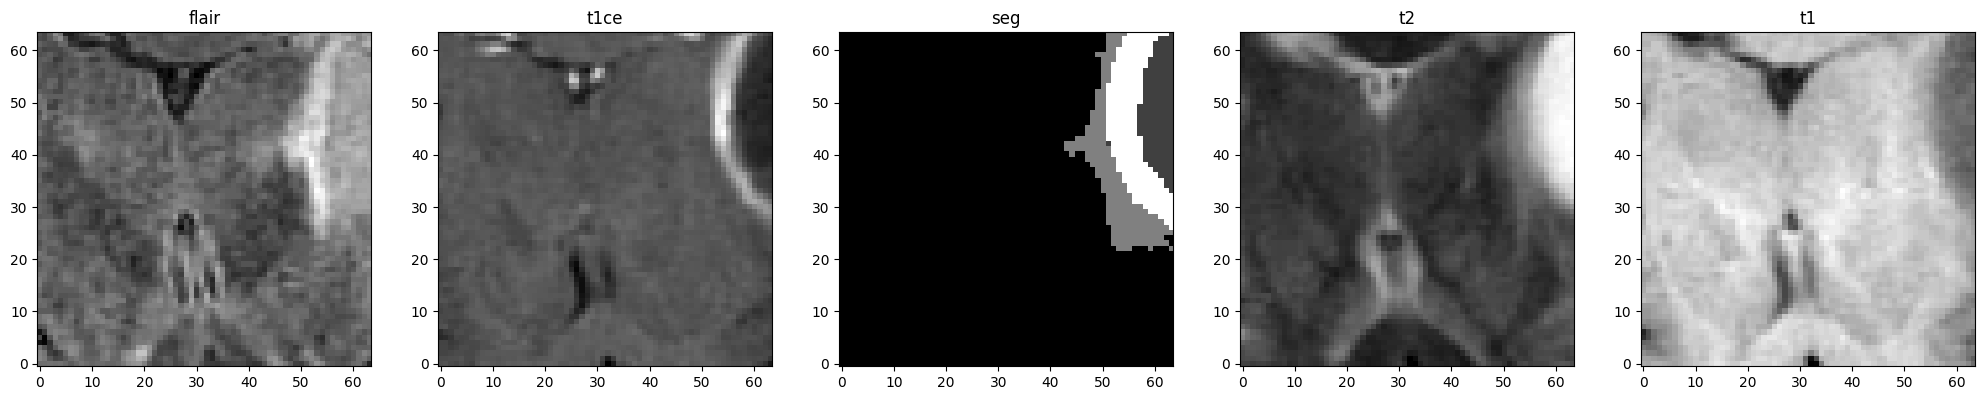

In [ ]:
file_path = "/content/drive/MyDrive/kaggle/Training"

fig,axes = plt.subplots(1,5, figsize=(25,10))
a = np.random.randint(1,100)
#for i in (os.listdir(file_path)):
i = os.path.join(file_path, (os.listdir(file_path)[2]))
subpath = i
for x, j in enumerate(os.listdir(subpath)):
    scans = (j.split("_"))[2][:-7] # to get label from filename
    img = nib.load(os.path.join(subpath,j))
    data = img.get_fdata()
    data = data[88:152, 88:152,46:110] #cropping into 128x128x128 shape
    # Choose a slice in the middle of the volume
    slice_index = data.shape[2] // 2
    axes[x].imshow(data[:, :, slice_index].T, cmap='gray', origin='lower')
    axes[x].set_title(scans)

    # Show the plot
plt.show()

In [ ]:
class BraTS3DDataGenerator(Sequence):
    def __init__(self, image_paths_dict, mask_paths, batch_size=2, n_channels=4, n_classes=3, shuffle=True):
        self.image_paths_dict = image_paths_dict  # Dictionary of image paths for each modality
        self.mask_paths = mask_paths              # List of paths for segmentation masks
        self.batch_size = batch_size              # Batch size (e.g., 4)
        self.n_channels = n_channels              # Number of input channels (e.g., 4 modalities)
        self.shuffle = shuffle                    # Whether to shuffle the data after each epoch
        self.on_epoch_end()                       # Initialize the indices and shuffle if needed
        self.n_classes = n_classes

    def __len__(self):
        # Number of batches per epoch
        return int(np.floor(len(self.mask_paths) / self.batch_size))

    def __getitem__(self, index):
        # Get batch indexes
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Gather batch file paths for each modality
        batch_image_paths = {modality: [self.image_paths_dict[modality][i] for i in batch_indexes] for modality in self.image_paths_dict}
        batch_mask_paths = [self.mask_paths[i] for i in batch_indexes]

        # Generate the batch data (X, y)
        X, y = self.__data_generation(batch_image_paths, batch_mask_paths)
        return X, y

    def on_epoch_end(self):
        # Shuffle data indices after each epoch
        self.indexes = np.arange(len(self.mask_paths)) #generate indexes
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, batch_image_paths, batch_mask_paths):

        # Initialize arrays to hold the batch data
        X = np.empty((self.batch_size, 128, 128, 128, self.n_channels))  # (batch_size, height, width, depth, channels)
        y = np.empty((self.batch_size, 128, 128, 128, self.n_classes))  # (batch_size, height, width, depth, classes)

        # Load and stack modalities and masks for each sample in the batch
        for i, mask_path in enumerate(batch_mask_paths):
            # Stack modalities for each patient along the channel axis
            img = np.stack([nib.load(batch_image_paths[modality][i]).get_fdata() for modality in batch_image_paths], axis=-1)
            mask = nib.load(mask_path).get_fdata()

            #croppping images into 128x128x128
            img_cropped = img[56:184, 56:184,14:142]
            mask_cropped = mask[56:184, 56:184,14:142]

            #grouping classes in mask to seperate the 3 classes in the labels
            mask_conv = np.zeros((128,128,128,self.n_classes), dtype=np.float32)
            # ... is used to select all preceding dimensions
            # if want to include background, which can increase accuracy but will increase complexity,
            #add one more as class 0 and other class +1
            mask_conv[..., 0] = (mask_cropped == 4).astype(np.float32) #class 0, enhancing tumor
            mask_conv[..., 1] = np.isin(mask_cropped, [1,4]).astype(np.float32) #class 1, tumor core
            mask_conv[..., 2] = np.isin(mask_cropped, [1,2,4]).astype(np.float32) #class 2, whole tumor

            # Convert to float
            img_cropped = img_cropped.astype(np.float32)

            # Add to the batch arrays
            X[i] = img_cropped
            y[i] = mask_conv

        return X, y


In [ ]:
def load_files(file_dir):
    image_paths_dict = {
        't1' : [],
        't2' : [],
        't1ce' : [],
        'flair' : []
    }

    mask_path = []

    for patient in (os.listdir(file_dir)):
        patient_path = os.path.join(file_dir, patient)
        t1_path = os.path.join(patient_path,f"{patient}_t1.nii.gz")
        t1ce_path = os.path.join(patient_path,f"{patient}_t1ce.nii.gz")
        t2_path = os.path.join(patient_path,f"{patient}_t2.nii.gz")
        flair_path = os.path.join(patient_path,f"{patient}_flair.nii.gz")
        seg_path = os.path.join(patient_path,f"{patient}_seg.nii.gz")

        image_paths_dict['t1'].append(t1_path)
        image_paths_dict['t2'].append(t2_path)
        image_paths_dict['t1ce'].append(t1ce_path)
        image_paths_dict['flair'].append(flair_path)

        mask_path.append(seg_path)

    return image_paths_dict, mask_path

In [ ]:
data_dir = "/content/drive/MyDrive/kaggle/Training"
image_paths_dict, mask_path = load_files(data_dir)

In [ ]:
#train and validation split
from sklearn.model_selection import train_test_split
train_img_paths_dict, val_img_paths_dict, train_mask_paths, val_mask_paths = train_test_split(
    image_paths_dict['flair'],
    mask_path,
    test_size = 0.15,
    random_state = 42
)

In [ ]:
train_generator = BraTS3DDataGenerator(
    image_paths_dict={
        'flair': train_img_paths_dict,
        't1': [p.replace('_flair.nii.gz','_t1.nii.gz') for p in train_img_paths_dict],
        't1ce': [p.replace('_flair.nii.gz','_t1ce.nii.gz') for p in train_img_paths_dict],
        't2': [p.replace('_flair.nii.gz','_t2.nii.gz') for p in train_img_paths_dict],
    },
    mask_paths=train_mask_paths,
    batch_size=4,
    n_channels=4,
    shuffle=True,
    n_classes=3
)

In [ ]:
val_generator = BraTS3DDataGenerator(
    image_paths_dict={
        'flair': val_img_paths_dict,
        't1': [p.replace('_flair.nii.gz','_t1.nii.gz') for p in val_img_paths_dict],
        't1ce': [p.replace('_flair.nii.gz','_t1ce.nii.gz') for p in val_img_paths_dict],
        't2': [p.replace('_flair.nii.gz','_t2.nii.gz') for p in val_img_paths_dict],
    },
    mask_paths=val_mask_paths,
    batch_size=4,
    n_channels=4,
    shuffle=True,
    n_classes=3
)

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras import layers

In [ ]:
def encoder(input_tensor, n_filters, kernel_size=(3,3,3)):
  x = layers.Conv3D(n_filters, kernel_size, padding='same')(input_tensor)
  x = layers.GroupNormalization(groups=2)(x)
  x = layers.ReLU()(x)

  x = layers.Conv3D(n_filters, kernel_size, padding='same')(input_tensor)
  x = layers.GroupNormalization(groups=2)(x)
  x = layers.ReLU()(x)

  return x

In [ ]:
def AttentionGate(input_tensor, n_filters, gating_signal):
  ds_x = layers.Conv3D(n_filters, (2,2,2), strides=(2,2,2), padding='same')(input_tensor) #matching dimesion to gating signal
  ds_gate = layers.Conv3D(n_filters,(1,1,1), padding='same')(gating_signal) #not necessary, just to match dimension to input tensor

  #addition and relu
  add_xgate = layers.add([ds_x, ds_gate])
  relu_xgate = layers.ReLU()(add_xgate)

  #conv and sigmoid operations to capture features
  psi = layers.Conv3D(1, (1,1,1), padding='same')(relu_xgate)
  sig = layers.Activation('sigmoid')(psi)

  #upsample to gating signal's original dimensions
  resampler = layers.UpSampling3D(size=(2,2,2))(sig)

  #attention output
  output = layers.multiply([input_tensor, resampler])

  return output

In [ ]:
def build_model(input_shape=(128,128,128,4), n_classes=3):
  inputs = layers.Input(input_shape)

  #5 layers of encoder
  e1 = encoder(inputs, 8, (3,3,3))
  p1 = layers.MaxPooling3D(pool_size=(2,2,2))(e1)

  e2 = encoder(p1, 16, (3,3,3))
  p2 = layers.MaxPooling3D(pool_size=(2,2,2))(e2)

  e3 = encoder(p2, 32, (3,3,3))
  p3 = layers.MaxPooling3D(pool_size=(2,2,2))(e3)

  e4 = encoder(p3, 64, (3,3,3))
  p4 = layers.MaxPooling3D(pool_size=(2,2,2))(e4)

  #bottleneck
  e5 = encoder(p4, 128, (3,3,3))

  #attention gates and upsampling
  a1 = AttentionGate(e4, 64, e5)
  u1 = layers.Conv3DTranspose(64, (2,2,2), strides=(2,2,2), padding='same')(e5)
  u1 = layers.concatenate([a1,u1])
  e6 = encoder(u1, 64)

  a2 = AttentionGate(e3, 32, e6)
  u2 = layers.Conv3DTranspose(32, (2,2,2), strides=(2,2,2), padding='same')(e6)
  u2 = layers.concatenate([a2,u2])
  e7 = encoder(u2, 32)

  a3 = AttentionGate(e2, 16, e7)
  u3 = layers.Conv3DTranspose(16, (2,2,2), strides=(2,2,2), padding='same')(e7)
  u3 = layers.concatenate([a3,u3])
  e8 = encoder(u3, 16)

  a4 = AttentionGate(e1, 8, e8)
  u4 = layers.Conv3DTranspose(8, (2,2,2), strides=(2,2,2), padding='same')(e8)
  u4 = layers.concatenate([a4, u4])
  e9 = encoder(u4, 8)


  #output
  outputs = layers.Conv3D(n_classes, (1,1,1), activation='softmax')(e9)

  model = Model(inputs=[inputs], outputs=[outputs])

  return model

In [ ]:
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    # Cast both tensors to float32 to avoid type mismatches
    y_true_f = tf.cast(tf.keras.backend.flatten(y_true), tf.float32)
    y_pred_f = tf.cast(tf.keras.backend.flatten(y_pred), tf.float32)

    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)


def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)


In [ ]:
model = build_model(input_shape=(128,128,128,4), n_classes=3)
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3), loss=dice_loss, metrics=['accuracy', dice_coefficient])

In [ ]:
hist = model.fit(train_generator, validation_data=val_generator, epochs=50, verbose=1,
                 steps_per_epoch=len(train_generator), validation_steps=len(val_generator))

Epoch 1/50
 63/266 ━━━━━━━━━━━━━━━━━━━━ 1:58:43 35s/step - accuracy: 0.1974 - dice_coefficient: 0.0596 - loss: 0.9404